# Assignment 2
Or *'How I Learned to Start Worrying and Hate All-Nighters Again'*

BMI 2005  
Due: 2/13/2019

By: **Ryan Neff**  
ryan.neff@icahn.mssm.edu

## Problem 1

As we discussed in class, simulation of a “real” liquid, such as a box of non-bonded particles at a given temperature and pressure, requires consideration of so-called periodic boundary conditions. In our simulation, we will assume the center of the box is at position `0,0,0` and that the initial vectors describing the extent of the box are equal (e.g., this box is a square!).   

Attached to this homework is a new `XYZ` file defining a box of 200 Lennard-Jones particles. The boundary vector for this box for a reasonable box temperature and pressure (we’ll get there later, don’t worry about this yet...) is **`3.21829795`**. The total length of the box is twice the vector length in each dimension, so this box is **`6.4365959`** in length in each dimension (x, y, and z).   

### Problem 1a

Implement a new total LJ potential function (as you did for problem 4(a) in the previous homework) which includes consideration of a periodic boundary, and compute the total potential for the system in the supplied new `XYZ` file (`lj-0200-liquid.xyz`).   

This will require you to correct the distance between atoms in each dimension. You may in the previous homework have written something like the following, which computes the distance based on the vector norm between the `x`, `y`, and `z` positions of two atoms, and the conditional defining your cutoff distance:

```
def distance(a, b):
    return np.linalg.norm(a - b)

def V_ij(r):
    return 4 *((1/r)**12 - (1/r)**6)

def lj_cut(atoms, r_cut): 
    n_atoms = a.shape[0] 
    LJ_potential = 0.0
    for i in range(n_atoms):
        for j in range(i + 1, n_atoms): 
            r = distance(a[i], a[j])
            if r < r_cut:
                LJ_potential += V_ij(r) 
    return LJ_potential
```

Because you will need to correct the distance between atoms in each dimension, based on the periodicity of the system, this approach will not quite work: you will need to consider the distance in each dimension between the two particles in your double loop. In this case, it is easiest to consider the square euclidian distance, because it allows you to easily accumulate the distance in each dimension and then simply take a square root at the end. E.g.,

$d^2(p,q) = (p_1-q_1)^2 + (p_2-q_2)^2 + ... + (p_i-q_i)^2 + ... + (p_n-q_n)^2$

In pseudowords, a good approach to this is the following:

```
for each atom i in the system
    for each pairwise interaction atom j
        square_distance ← 0.0 
        for each dim
            distance_in_dim ← a[i][dim] - a[j][dim] 
            distance_in_dim -= boundary_length[dim] * \
                round(distance_in_dim / boundary_length[dim]) 
            square_distance += distance_in_dim ** 2
        distance = sqrt(square_distance) 
        if (distance < cutoff...)...
```

Where `distance_in_dim` is modified using the supplied function.

In [53]:
import numpy as np
import re

def read_xyz(input_filename):
    '''read_xyz(input_filename)
    Reads an XYZ file to a numpy float32 array.

    Inputs:
        input_filename
            Filename of XYZ file on disk. 

            File format: 
                line 1: <number of atoms / lines>
                line2: <comment>
                line 3+: <atom type> <x> <y> <z>
    
    Returns: 
        output
            Array of 3D positions of atoms in file. 
    '''

    number_of_atoms, comment, output = None, None, []
    with open(input_filename,"r") as fp:
        for line in fp:
            line = line.strip() #clean input
            if number_of_atoms == None:
                number_of_atoms = int(line)
            elif comment == None:
                comment = line
            else:
                splitline = [float(a) for a in re.split(" +",line)[1:]]
                output.append(splitline)
    output = np.array(output,dtype="float32")
    return output

def V_ij(r):
    '''V_ij(r)
     Computes the potential energy V_ij between two atoms i and j
     with distance r where e and s are set to 1

     Inputs: 
        r (float)
            Distance between two atoms i and j
    
    Outputs:
        V_ij (float)
            Potential energy between two atoms
    '''
    return 4 *((1/r)**12 - (1/r)**6)

def LJ_potential(atoms,boundary_length=[6.4365959]*(3), cutoff=False):
    '''LJ_potential(atoms,boundary_length=[6.4365959]*(3), cutoff=False)
    Calculates the energy potential of the system for a set of atoms 
    based on N-dimensional coordinates, using the LJ potential equation. 
    
    Inputs: 
        atoms
            An array atoms, with each atom being a row of
            n-dimensions with position information.
        boundary_length
            The boundary distance vector over some periodic interaction
            function occurs.
        cutoff
            Whether a cutoff distance exists to consider interactions is set. 
            Either False or a number indicating the cutoff distance.
    
    Returns:
        total_energy (float)
            The total energy of the system.
    '''
    total_energy = 0
    dimensions = range(0,len(atoms[0]))
    for atom1 in range(0,len(atoms)):
        for atom2 in range(atom1+1,len(atoms)):
            square_dist = 0
            for dim in dimensions:
                dist_in_dim = atoms[atom1,dim] - atoms[atom2,dim]
                dist_in_dim -= boundary_length[dim] * round(dist_in_dim/boundary_length[dim]) ##??
                dist_in_dim = dist_in_dim
                square_dist += dist_in_dim**2
            distance = np.sqrt(square_dist)
            if cutoff:
                if distance < cutoff: 
                    total_energy += V_ij(distance)
            else:
                total_energy += V_ij(distance)
    return total_energy

In [56]:
LJ_potential(read_xyz("lj-0200-liquid.xyz"))

-1002.2429537424274

### Problem 1b

Compute the new potential energy for the system using your new function and a
cutoff value of 2.0. Report the value.

In [102]:
LJ_potential(read_xyz("lj-0200-liquid.xyz"), cutoff=2.0)

-862.15524954568468

## Problem 2

We discussed two methods of list construction, the Verlet list, and the cell list, which can be implemented by an elementary hash table, and a linked list, respectively.

<img src="https://i.imgur.com/bA3ogu4.png" width=300>

### Problem 2b

First, we will implement a static Verlet list and rewrite our potential energy function once again to accommodate this new data structure. Constructing the list involves looping over all atom pairs, determining which pairs are within the cutoff + sheath distance, and constructing two arrays: a lookup table, where the location of pair information can be found for each atom, and a value table, where all pair atoms are found. The number of pairwise interactions per atom can be determined purely by the values in the lookup table, by comparing the position in the value table for the current and next atom.

Just like our previous attempt at a new potential function, periodicity must be considered. A pseudoword attempt at the list function might look like, for a cutoff of 2.0 and a sheath of 0.3:

```
cutoff ← 2.0
sheath ← 0.3
cutoff_plus_sheath ← cutoff + sheath
lookup ← empty numpy array of integers, length n_atoms 
value ← unknown length, placeholder array
pair_counter ← 0
for each atom i in the system
    for each pairwise interaction atom j 
        square_distance ← 0.0
        for each dim
            distance_in_dim ← a[i][dim] - a[j][dim] 
            distance_in_dim -= boundary_length[dim] * \
                round(distance / boundary_length[dim]) square_distance += distance_in_dim ** 2
            square_distance += distance
        distance = sqrt(square_distance) 
        if (distance < cutoff_plus_sheath)
            pair_counter ← pair_counter + 1
            value ← push pair index j onto array 
        lookup[i] ← pair_counter
```

In [98]:
def calculate_pairs_verlet(atoms, boundary_length = [6.4365959]*(3), cutoff=2.0, sheath=0.3):
    '''calculate_pairs_verlet(atoms, cutoff=2.0, sheath=0.3)
    Calculates which atoms interact in a set of atoms based on their 
    N-dimensional coordinates. This function implements this via use 
    of a Verlet list.
    
    Inputs: 
        atoms
            A numpy array of atoms, with each atom being a row of
            n-dimensions with position information.
        boundary_length
            The boundary distance box over which some periodic 
            interaction function occurs. Default = [6.4365959]*(3).
        cutoff
            The cutoff distance to consider interactions is set, 
            as a number. Default = 2.0.
        sheath
            The sheath distance within to consider interactions.
            Default = 0.3.
    
    Returns:
        lookup
            lookup table for verlet list
        value
            value table for verlet list
    '''
    total_energy = 0
    dimensions = range(0,len(atoms[0]))
    cutoff_plus_sheath = cutoff + sheath
    lookup = [0]*(len(atoms))
    value = []
    pair_counter = 0
    for atom1 in range(0,len(atoms)):
        lookup[atom1] = pair_counter ## this needs to be initialized in the beginning, not the end
        for atom2 in range(atom1+1,len(atoms)):
            square_dist = 0
            for dim in dimensions:
                dist_in_dim = atoms[atom1,dim] - atoms[atom2,dim]
                dist_in_dim -= boundary_length[dim] * round(dist_in_dim/boundary_length[dim]) ##??
                dist_in_dim = dist_in_dim
                square_dist += dist_in_dim**2
            distance = np.sqrt(square_dist)
            if distance < cutoff_plus_sheath: 
                pair_counter += 1
                value.append(atom2) #why not save a lot of time here?
    return lookup,value

### Problem 2b

After implementing the above pairwise function to generate a Verlet list, implement a total potential energy function that takes as input both arrays in the Verlet list, with appropriate control logic to only include those atoms within the cutoff but not within the sheath. Argue for why the complexity of this function is now O(N).

In [99]:
def LJ_potential_verlet(atoms,lookup_value, boundary_length = [6.4365959]*(3), cutoff=2):
    '''
    Inputs:
        lookup_value
            Tuple of (lookup, value) from calculate_pairs_verlet().
        cutoff
            The cutoff distance to consider interactions is set, 
            as a number. Default = 2.0.
    Returns: 
        total_energy (float)
            The total energy of the system.
    '''
    lookup, value = lookup_value
    total_energy = 0
    dimensions = range(0,len(atoms[0]))
    for atom1 in range(0,len(lookup)):
        start = lookup[atom1]
        end = lookup[atom1+1] if atom1 < (len(lookup)-1) else len(value)
        pair_atoms = value[start:end]
        for atom2 in pair_atoms:
            square_dist = 0
            for dim in dimensions:
                dist_in_dim = atoms[atom1,dim] - atoms[atom2,dim]
                dist_in_dim -= boundary_length[dim] * round(dist_in_dim/boundary_length[dim]) ##??
                dist_in_dim = dist_in_dim
                square_dist += dist_in_dim**2
            distance = np.sqrt(square_dist)
            if distance==0: raise
            if distance < cutoff:
                total_energy += V_ij(distance)
    return total_energy

In [103]:
atoms = read_xyz("lj-0200-liquid.xyz")
LJ_potential_verlet(atoms, calculate_pairs_verlet(atoms))

-862.15524954568468

The complexity of this function is now $O(n)$ because we assume that each atom only has a limited number of interaction pairs (say, $10$ on average) and therefore, we are only iterating over $N*10$ atoms on average, even if the number of atoms becomes very large.

## Problem 3

Now we will tackle the linked cell formulation, which is the first method we will cover to transform this problem into a true linear or logarithmetic problem. We will start with a very simple implementation of the cell list method, simply creating an appropriate set of linked lists, and continue to improve on our implementation with time once we start actually moving atoms in the simulation.

### Problem 3a

Given a fixed box length of 6.4365959 in all directions, and a cutoff of 2.0, what would be an appropriate size for a cell-based domain decomposition of this box? Why? (Hint: we covered this in the 4th week of class).

**Answer:** We would split up the box into a $3*3*3$ set of cells, so that all of the interactions (and the sheath) will almost all nicely fit within the box. 

### Problem 3b

Create an array of linked lists for a 3x3x3 (27 lists) decomposition of the array. How you index the position of each cell is up to you, but you need to know which area of the box each cell represents! Each node in each of the linked list should contain at a minimum a index value (the index of the atom) and a pointer to next.

In [155]:
from copy import copy

class Atom:
    def __init__(self,atom_index, position):
        self.index = atom_index
        self.position = position
        self.next = None
    def getIndex(self):
        return self.index
    def getNext(self):
        return self.next
    def setIndex(self,new_atom_index):
        self.index = new_atom_index
    def setNext(self,newnext):
        self.next = newnext
    def __hash__(self):
        return self.index
    def __repr__(self):
        return "<Atom, index='{}'>".format(self.index)
    def __str__(self):
        return self.__repr__()
    def __eq__(self,other):
        return self.__hash__() == other.__hash__()

class Cell:
    def __init__(self,x,y,z):
        self.head = None
        self.x = x #x-index
        self.y = y #y-index
        self.z = z #z-index
    
    def add(self,atom_index, position): #ADDS to front of list (so it will be in reverse order!)
        tmp = self.head
        newnode = Atom(atom_index,position)
        self.head = newnode
        self.head.setNext(tmp)
    
    def get_index(self,pos):
        node = self.head
        if pos > self.size():
            raise IndexError(pos)
        for i in range(1,pos):
            node = node.getNext()
        return node
            
    def size(self):
        count = 0
        node = self.head
        while type(node) != type(None):
            count += 1
            node = node.getNext()
        return count
    def __repr__(self):
        return "<Cell, position='{}',n_atoms={}>".format((self.x,self.y,self.z),self.size())

### Problem 3c

* Create an array or other data structure that specifies which cell neighbors are adjacent. Remember, in 3D each cell is 26 neighbors with periodic boundary conditions!

* Implement an append function which allows you to easily add a new node to an arbitrary list by supplying the appropriate index to instantiate the node within the appropriate cell list. This method should handle the case where the linked list is empty and the head of the list has not yet been assigned.

* Loop over all atoms in the simulation and assign them to a cell by instantiating a node in each cell as appropriate.

In [180]:
adjacent_cells = dict()
for x in range(0,3):
    neighbors_x = list(range(max(x-1,0),min(x+1,2)+1))
    for y in range(0,3):
        neighbors_y = list(range(max(y-1,0),min(y+1,2)+1))
        for z in range(0,3):
            neighbors_z = list(range(max(y-1,0),min(y+1,2)+1))
            adjacent_cells[(x,y,z)] = []
            for nx in neighbors_x:
                for ny in neighbors_y:
                    for nz in neighbors_z:
                        if (x,y,z) == (nx,ny,nz): continue ## cannot be the same cell
                        adjacent_cells[(x,y,z)].append((nx,ny,nz))

In [181]:
adjacent_cells

{(0, 0, 0): [(0, 0, 1),
  (0, 1, 0),
  (0, 1, 1),
  (1, 0, 0),
  (1, 0, 1),
  (1, 1, 0),
  (1, 1, 1)],
 (0, 0, 1): [(0, 0, 0),
  (0, 1, 0),
  (0, 1, 1),
  (1, 0, 0),
  (1, 0, 1),
  (1, 1, 0),
  (1, 1, 1)],
 (0, 0, 2): [(0, 0, 0),
  (0, 0, 1),
  (0, 1, 0),
  (0, 1, 1),
  (1, 0, 0),
  (1, 0, 1),
  (1, 1, 0),
  (1, 1, 1)],
 (0, 1, 0): [(0, 0, 0),
  (0, 0, 1),
  (0, 0, 2),
  (0, 1, 1),
  (0, 1, 2),
  (0, 2, 0),
  (0, 2, 1),
  (0, 2, 2),
  (1, 0, 0),
  (1, 0, 1),
  (1, 0, 2),
  (1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (1, 2, 0),
  (1, 2, 1),
  (1, 2, 2)],
 (0, 1, 1): [(0, 0, 0),
  (0, 0, 1),
  (0, 0, 2),
  (0, 1, 0),
  (0, 1, 2),
  (0, 2, 0),
  (0, 2, 1),
  (0, 2, 2),
  (1, 0, 0),
  (1, 0, 1),
  (1, 0, 2),
  (1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (1, 2, 0),
  (1, 2, 1),
  (1, 2, 2)],
 (0, 1, 2): [(0, 0, 0),
  (0, 0, 1),
  (0, 0, 2),
  (0, 1, 0),
  (0, 1, 1),
  (0, 2, 0),
  (0, 2, 1),
  (0, 2, 2),
  (1, 0, 0),
  (1, 0, 1),
  (1, 0, 2),
  (1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (1, 2, 0),
  (1, 

For ii: **Append is already handled in my Cell class**

In [177]:
atoms = read_xyz("lj-0200-liquid.xyz")

box_boundaries = [6.4365959]*(3) #boundaries of box in x,y,z

cells_in_box = dict()
for x in range(0,3):
    cells_in_box[x] = dict()
    for y in range(0,3):
        cells_in_box[x][y] = dict()
        for z in range(0,3):
            cells_in_box[x][y][z] = Cell(x,y,z)

count = 0
for atom_ix in range(0,len(atoms)):
    atom_pos = atoms[atom_ix]
    cell_x = (atom_pos[0]+box_boundaries[0]/2)//(box_boundaries[0]/3)
    cell_y = (atom_pos[1]+box_boundaries[1]/2)//(box_boundaries[1]/3)
    cell_z = (atom_pos[2]+box_boundaries[2]/2)//(box_boundaries[2]/3)
    if (cell_x < 0)|(cell_x>2): continue ##only handle atoms in the box
    if (cell_y < 0)|(cell_y>2): continue ##only handle atoms in the box
    if (cell_z < 0)|(cell_z>2): continue ##only handle atoms in the box
    cells_in_box[cell_x][cell_y][cell_z].add(atom_ix,atom_pos)
    count += 1
print("{} atoms added to box.".format(count))

200 atoms added to box.


In [178]:
for x in range(0,3):
    for y in range(0,3):
        for z in range(0,3):
            print(cells_in_box[x][y][z])

<Cell, position='(0, 0, 0)',n_atoms=8>
<Cell, position='(0, 0, 1)',n_atoms=7>
<Cell, position='(0, 0, 2)',n_atoms=7>
<Cell, position='(0, 1, 0)',n_atoms=7>
<Cell, position='(0, 1, 1)',n_atoms=8>
<Cell, position='(0, 1, 2)',n_atoms=7>
<Cell, position='(0, 2, 0)',n_atoms=8>
<Cell, position='(0, 2, 1)',n_atoms=7>
<Cell, position='(0, 2, 2)',n_atoms=5>
<Cell, position='(1, 0, 0)',n_atoms=6>
<Cell, position='(1, 0, 1)',n_atoms=8>
<Cell, position='(1, 0, 2)',n_atoms=9>
<Cell, position='(1, 1, 0)',n_atoms=7>
<Cell, position='(1, 1, 1)',n_atoms=10>
<Cell, position='(1, 1, 2)',n_atoms=6>
<Cell, position='(1, 2, 0)',n_atoms=7>
<Cell, position='(1, 2, 1)',n_atoms=9>
<Cell, position='(1, 2, 2)',n_atoms=12>
<Cell, position='(2, 0, 0)',n_atoms=6>
<Cell, position='(2, 0, 1)',n_atoms=7>
<Cell, position='(2, 0, 2)',n_atoms=6>
<Cell, position='(2, 1, 0)',n_atoms=6>
<Cell, position='(2, 1, 1)',n_atoms=9>
<Cell, position='(2, 1, 2)',n_atoms=7>
<Cell, position='(2, 2, 0)',n_atoms=8>
<Cell, position='(2, 2,

## Problem 4

In class, we discussed the extension of the 1D peak problem to 2 dimensions. Write an implementation of two_peak() that returns a peak (as defined by an entry greater than or equal to its 4 neighbor values). Run it on the given array, and assess the complexity in terms of O(n) (in theory, not with doubling experiments unless you'd prefer!).

```
import numpy as np
A = np.array([
        [1, 3, 10, 2], 
        [14, 13, 12, 5], 
        [15, 9, 11, 6], 
        [16, 17, 13, 18]
])
```

In [245]:
import numpy as np
A = np.array([
        [1, 3, 10, 2], 
        [14, 13, 12, 5], 
        [15, 9, 11, 6], 
        [16, 17, 13, 18]
])

def two_peak(A):
    A = A.T
    columns = len(A)
    rows = len(A[0])
    if columns > 1:
        mid = columns//2
        pivot = A[mid]
        peak_pivot = max(pivot)
        peak_pivot_ix = list(pivot).index(peak_pivot)
        if (mid-1 >= 0):
            neighbor_left = A[mid-1][peak_pivot_ix] if mid-1 >= 0 else False
            neighbor_right = A[mid+1][peak_pivot_ix] if mid+1 < columns else False
            if neighbor_left:
                if neighbor_left > peak_pivot:
                    if neighbor_right:
                        if (neighbor_left > neighbor_right):
                            return two_peak(A[0:mid].T)
                        else:
                            return two_peak(A[mid+1:columns].T)
                    else:
                        return two_peak(A[0:mid].T)
                else:
                    if neighbor_right:
                        if neighbor_right > peak_pivot:
                            return two_peak(A[mid+1:columns].T)
                    else:
                        return peak_pivot
            else:
                if neighbor_right:
                        if neighbor_right > peak_pivot:
                            return two_peak(A[mid+1:columns].T)
                
    else:
        return max(list(A[0]))

In [246]:
two_peak(A)

18

**Answer:** This solution is $O(N*log(N))$, since you only iterate over log(N) columns but do iterate over all N rows.

## Problem 5

Conduct doubling experiments to compare the run time of selection vs insertion vs merge vs quick (randomized vs non-randomized) in various cases. Plot the results (all 5 sorts per case of array) for array sizes n = 2, 4, ... 1024. The functions from lab are provided below - helper 'wrapper' functions for quicksort (randomized and nonrandomized) are also included so that all the sort functions are a function of an input array A only. The five cases are as follows:  

a) A is perfectly sorted and contains random integers (0 to 100 inclusive).  
b) A is reversely sorted and contains random integers (0 to 100 inclusive)  
c) A has a random order of integers from 0 to 100 inclusive.  
d) A is made of entirely identical entries (all 1s).  
e) A is composed of 3 distinct entries (in random order) i.e. 0, 1 and 2.  

Do the results agree with what you expect?  

In [248]:
import time
import numpy as np

def selection_sort(A):
    for i in range(len(A)):
        min_idx = i
        for j in range(i + 1, len(A)):
            if A[min_idx] > A[j]:
                min_idx = j
        A[i], A[min_idx] = A[min_idx], A[i]
    return A

def insertion_sort(A):
    n = len(A)
    count = 0 
    for i in range(1,n):
        k = i
        while k > 0 and A[k] < A[k-1]:
            A[k], A[k-1] = A[k-1], A[k]
            k = k - 1
            count += 1
    return count, A

def merge(front, back):
    pos_f, pos_b = 0,0
    merged = np.zeros(len(front)+len(back))
    for i in range (len(merged)):
        if pos_f == len(front):
            merged[i] = back[pos_b]
            pos_b += 1
        elif pos_b == len(back):
            merged[i] = front[pos_f]
            pos_f += 1
        elif front[pos_f] < back[pos_b]:
            merged[i] = front[pos_f]
            pos_f += 1
        else:
            merged[i] = back[pos_b]
            pos_b += 1
    return merged

def merge_sort(A):
    n = len(A)
    if n <= 1:
        return A
    mid = int(n/2)
    front = merge_sort(A[0:mid])
    back = merge_sort(A[mid:])
    return merge(front, back)

def partition(A, lo, hi):
    pivotvalue = A[lo]
    i = lo+1    
    j = hi
    done = False
    while not done:
        while i <= j and A[i] <= pivotvalue:
            i = i + 1
        while A[j] >= pivotvalue and j >= i:
            j = j - 1
        if j < i:
            done = True
        else:
            A[i], A[j] = A[j], A[i]
    A[lo], A[j] = A[j], A[lo]
    return j, A

def quick_sort(A, lo, hi):
    if lo < hi:
        splitpoint, A = partition(A, lo, hi)
        A = quick_sort(A, lo, splitpoint - 1)
        A = quick_sort(A, splitpoint + 1, hi)    
    return A

def quick_sort_helper_rand(A):
    np.random.shuffle(A)
    return quick_sort(A, 0, len(A)-1)

def quick_sort_helper_nonrand(A):
    return quick_sort(A, 0, len(A)-1)


In [290]:
import time 

def runtime(function,params,iters=10):
    t0 = time.time()  # start time
    for i in range(iters):
        function(*params)
    t1 = time.time() # end time
    return(t1-t0)

def calc_time_doubling(function,mode,start = 1,end=10):
    '''
    a) A is perfectly sorted and contains random integers (0 to 100 inclusive).
    b) A is reversely sorted and contains random integers (0 to 100 inclusive)
    c) A has a random order of integers from 0 to 100 inclusive.
    d) A is made of entirely identical entries (all 1s).
    e) A is composed of 3 distinct entries (in random order) i.e. 0, 1 and 2.
    '''
    timings = []
    sizes = []
    for size in range(start,end+1):
        if mode=="a":
            A = sorted(np.random.randint(0,100,size=2**size))
        elif mode=="b":
            A = sorted(np.random.randint(0,100,size=2**size),reverse=True)
        elif mode=="c":
            A = np.random.randint(0,100,size=2**size)
        elif mode=="d":
            A = np.ones(2**size)
        elif mode=="e":
            A = np.random.randint(0,2,size=2**size)
        else:
            raise Exception("Invalid mode. Please select from a-e.")
        timing = runtime(function,[A])
        timings.append(timing)
        sizes.append(2**size)
    return timings, sizes

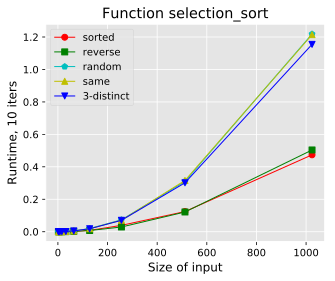

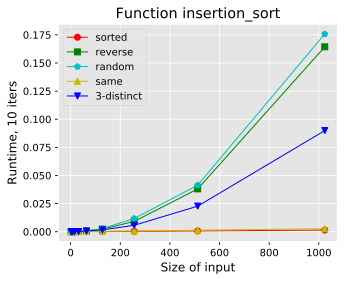

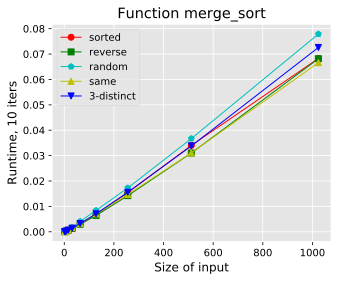

quick_sort_helper_rand , mode: same , error: maximum recursion depth exceeded in comparison


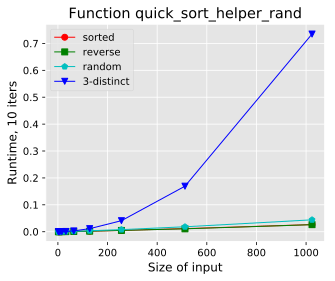

quick_sort_helper_nonrand , mode: reverse , error: maximum recursion depth exceeded in comparison
quick_sort_helper_nonrand , mode: same , error: maximum recursion depth exceeded in comparison


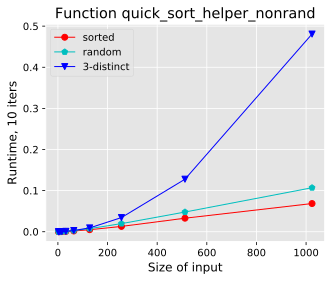

In [294]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

plt.style.use('ggplot')
rcParams['figure.figsize'] = (5,4)
rcParams['figure.dpi'] = 200
rcParams['font.family'] = 'DejaVu Sans'

COLOR = 'black'
rcParams['text.color'] = COLOR
rcParams['axes.labelcolor'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR

colors = {"a":"ro-",
          "b":"gs-",
          "c":"cp-",
          "d":"y^-",
          "e":"bv-"}
modes = {"a":"sorted",
         "b":"reverse",
         "c":"random",
         "d":"same",
         "e":"3-distinct"}
for function in (selection_sort, insertion_sort, merge_sort, quick_sort_helper_rand, quick_sort_helper_nonrand):
    modes_ran = []
    for mode in ["a","b","c","d","e"]:
        try:
            times, sizes = calc_time_doubling(function,mode)
            plt.plot(sizes,times,colors[mode],linewidth="1")
            modes_ran.append(mode)
        except Exception as err:
            print(function.__name__,", mode:",modes[mode],", error:",err)
    plt.legend([modes[mode] for mode in modes_ran])
    plt.title("Function "+function.__name__)
    plt.xlabel("Size of input")
    plt.ylabel("Runtime, 10 iters")
    plt.show()

**Answer:** Yes, the results are what I expected. Selection sort and insertion sort are roughly $O(n^2)$ (but insertion sort can be $O(n)$ in best case, merge_sort is linear time $O(n*log(n))$ always, and quick sort is linear in the average case and O(n^2) in the worst case (some of them didn't finish due to recursion errors, which I printed in the output).

## Problem 6

6) Solve the following recurrences (i.e. find a closed form expression for n).

=====

**a)** S(0) = 6    for n=0   
   S(n) = S(n-1) + 2     for n=1, 2, 3, ...  

**Answer:**  
$S(n) = 6+2*n$  

Work:  
S(0) = 6 = 6+2\*0  
S(n) = S(n-1) + 2  
S(n) = 6+2(n-1)+2 
S(n) = 6+2(n-1+1)  
S(n) = 6+2\*n 

=====

**b)** T(1) = 2     for n=1   
   T(n) = 2T(n-1) + 4    for n=2, 3, 4, ...  
   
**Answer:**  
$T(n) = 2^n + 4*\sum\limits_{k=0}^{n-2} 2^k$

**Work:**  

$T(2) = 2*T(1)+4$   
$T(2) = 2*2 + 4$    
$T(3) = 2*(2*2 + 4) + 4 = 2^3 + 4*2 + 4 = 2^3 + 4(2^1+2^0)$  
$T(4) = 2*(2*(2*2 + 4) + 4)+4 = 2^4 + 4*2^2 + 4*2 + 4 = 2^4 + 4(2^2+2^1+2^0)$  

$\therefore  T(n) = 2^n + 4*\sum\limits_{k=0}^{n-2} 2^k$

## Problem 7
```
The number of comparisons in merge sort can be written as   
	T(1) = 0 			for n = 1,   
	(a subarray of 1 element requires no comparisons)  

	T(n) = 2T(n/2) + (n-1)		for n = 2, 4, 8 …  
	(derived from T(n/2) comparisons to get the 
    first half of the array, another T(n/2) for the second half 
    and n-1 to merge them)  

What is a closed form expression for T(n)?
```

##### Answer

$T(n) = n*log_2(n) + (n+1)$

Work:  
$T(n) = 2T(n/2) + (n-1)$  
$= 2^1*T(n/2^1) + 1$  
$= 2 * (2T(n/4) + (n/2-1)) + (n-1) $  
$= 4T(n/4) + 2n + 1$  

$T(n) = 2^2*T(n/2^2) + 2n + 1= ...$ and so on  

for sake of simplicity, let k be any number at some recursion depth:

$T(n) = 2^{k}*T(n/2^{k}) + kn+1$

let $k = log_2(n)$:  

$T(n) = 2^{log_2(n)}*T(n/2^{log_2(n)}) + (log_2(n) − 1)*n+1$  
$T(n) = n*(0) + (log_2(n) − 1)*n+1$  
$\therefore ~ T(n) = n*log_2(n) + (n+1)$

## Problem 8

Here we will work towards a better quicksort algorithm based on modifications discussed in the lab.

### Problem 8a

Draw traces to show what happens when you pivot on using 13 as the pivot when partition (as defined in the lab) is called i.e. 

```
A = [13, 19, 9, 5, 9, 8, 11, 9, 6]
partition(A, lo = 0, hi = len(A)-1)
```

In [297]:
A = [13, 19, 9, 5, 9, 8, 11, 9, 6]

def quick_sort(A, lo, hi):
    if lo < hi:
        splitpoint, A = partition(A, lo, hi)
        A = quick_sort(A, lo, splitpoint - 1)
        A = quick_sort(A, splitpoint + 1, hi)    
    return A

def partition(A, lo, hi):
    print(A)
    pivotvalue = A[lo]
    i = lo+1    
    j = hi
    done = False
    while not done:
        while i <= j and A[i] <= pivotvalue:
            i = i + 1
        while A[j] >= pivotvalue and j >= i:
            j = j - 1
        if j < i:
            done = True
        else:
            A[i], A[j] = A[j], A[i]
            print(A)
    A[lo], A[j] = A[j], A[lo]
    print(A)
    return j, A

quick_sort(A,lo = 0, hi = len(A)-1)

[13, 19, 9, 5, 9, 8, 11, 9, 6]
[13, 6, 9, 5, 9, 8, 11, 9, 19]
[9, 6, 9, 5, 9, 8, 11, 13, 19]
[9, 6, 9, 5, 9, 8, 11, 13, 19]
[8, 6, 9, 5, 9, 9, 11, 13, 19]
[8, 6, 9, 5, 9, 9, 11, 13, 19]
[8, 6, 5, 9, 9, 9, 11, 13, 19]
[5, 6, 8, 9, 9, 9, 11, 13, 19]
[5, 6, 8, 9, 9, 9, 11, 13, 19]
[5, 6, 8, 9, 9, 9, 11, 13, 19]
[5, 6, 8, 9, 9, 9, 11, 13, 19]
[5, 6, 8, 9, 9, 9, 11, 13, 19]


[5, 6, 8, 9, 9, 9, 11, 13, 19]

### Problem 8b

So far we've discussed quicksort that partitions each array into two components based on a pivot v (one portion greater than or equal to v, the other half less than or equal to v). However, such a partition can lead to potentially poor performances when the array contains duplicates. Here we implement a 3-way quicksort that partitions the array into thirds. Convert the following from pseudocode to Python.

```
quicksort_3way(A, lo, hi)
    if hi <= lo
        return A
    lt, i, gt = lo, lo + 1, hi
    v = A[lo]
    while i <= gt
        if A[i] < v
            exchange A[lt], A[i]
            increase i and lt by 1
        elif A[i] > v
            exchange A[i], A[gt]
            decrease gt by 1
        else
            increase i by 1
    A <- quicksort_3way(A, lo, lt - 1)
    A <- quicksort_3way(A, gt + 1, hi)
return A
```

In [309]:
def quicksort_3way(A, lo, hi):
    if hi <= lo:
        return A
    lt, i, gt = lo, lo + 1, hi
    v = A[lo]
    while i <= gt:
        if A[i] < v:
            A[lt], A[i] = A[i], A[lt]
            i += 1
            lt += 1
        elif A[i] > v:
            A[i], A[gt] = A[gt], A[i]
            gt -= 1
        else:
            i += 1
    A = quicksort_3way(A, lo, lt - 1)
    A = quicksort_3way(A, gt + 1, hi)
    print(i)
    return A

### Problem 8c

What value does i terminate on (in the first outermost recursive call) when quicksort_3way runs with pivot value 2 on the following array (using the first entry as a pivot)?

```
A = [2, 3, 1, 2, 2, 2, 3, 3]
quicksort_3way(A, 0, len(A) - 1)
```


In [310]:
A = [2, 3, 1, 2, 2, 2, 3, 3]
quicksort_3way(A, 0, len(A) - 1)

8
5


[1, 2, 2, 2, 2, 3, 3, 3]

**Answer:** 8

## Problem 9

Consider the following sorting algorithm:

```
Funny-sort (A, i,j): 
    if A[i] > A[j]
        Exchange A[i] <-> A[j]
    if (i + 1)>= j
        return
    k <- int((j-i+1)/3) # the "int" function acts as floor
    Funny-sort(A, i, j-k) 
    Funny-sort(A, i+k, j) 
    Funny-sort(A, i, j-k)
```

### Problem 9a

Does this correctly sort the array? Why?

In [326]:
def funny_sort(A,i,j): 
    if A[i] > A[j]:
        A[i], A[j] = A[j],A[i]
    if (i + 1)>= j:
        return A
    k = int((j-i+1)/3) # the "int" function acts as floor
    A = funny_sort(A, i, j-k) 
    A = funny_sort(A, i+k, j) 
    A = funny_sort(A, i, j-k)
    return A

In [327]:
A = [13, 19, 9, 5, 9, 8, 11, 9, 6]
funny_sort(A, 0, len(A) - 1)

[5, 6, 8, 9, 9, 9, 11, 13, 19]

**Answer:** Yes, the array is sorted. It sorts the array from the outside in recursively, swapping values at the ends until the whole thing is sorted. But it sorts only 2/3rds of the array at a time or something.

### Problem 9b

Give a recurrence for this (e.g. something like T(n) = ?)

**Answer:** (Not attempted)

### Problem 9c

Ignoring constant factors and smaller terms, guess whether the worst case (O(n)) running time is better, the same, or worse than MergeSort?

**Answer**: The same as MergeSort, because it is recursively dividing the array. 